In [1]:
import os

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
from rdquantum.hamiltonian import Rydberg_Cz

In [2]:
# Define Hamiltonian
H = Rydberg_Cz()

In [3]:
# Create environment
env = gym.make('rdquantum/HamiltonianTrainer-v2023.04.22', Hamiltonian=Rydberg_Cz)
observation, info = env.reset()
# print(observation, info)

In [4]:
# Hyperparameters
algo = 'REINFORCE'
B = 30 # batch_size
EPOCHS = 500
eval_interval = 5
lr = 1e-2 # 1e-2 for SGD
policy_steps = 20

log_prob_clip = 5
grad_clip = 0.001
importance_ratio_eps = 0.2
value_loss_coeff = 0.5

optimizer = tf.optimizers.Adam(learning_rate=lr)
# optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr)

In [5]:
# rootdir = r'.'
r_amp = H.r_amp
r_gate_time = H.r_gate_time
# print(r_amp, r_gate_time)


# trainable variables
actions = ['omega_p_amp', 'omega_r_amp', 'delta_p_amp', 'gate_time']
mean = {s : tf.Variable(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32), name='mean_'+s) for s in actions}
sigma = {s : tf.Variable(0.5, name='sigma_'+s) for s in actions}
baseline = tf.Variable(0.0, name='baseline')

In [6]:
print(mean)
print(sigma)
print(baseline)

{'omega_p_amp': <tf.Variable 'mean_omega_p_amp:0' shape=() dtype=float32, numpy=0.23297977>, 'omega_r_amp': <tf.Variable 'mean_omega_r_amp:0' shape=() dtype=float32, numpy=0.8162606>, 'delta_p_amp': <tf.Variable 'mean_delta_p_amp:0' shape=() dtype=float32, numpy=0.99337316>, 'gate_time': <tf.Variable 'mean_gate_time:0' shape=() dtype=float32, numpy=0.98336244>}
{'omega_p_amp': <tf.Variable 'sigma_omega_p_amp:0' shape=() dtype=float32, numpy=0.5>, 'omega_r_amp': <tf.Variable 'sigma_omega_r_amp:0' shape=() dtype=float32, numpy=0.5>, 'delta_p_amp': <tf.Variable 'sigma_delta_p_amp:0' shape=() dtype=float32, numpy=0.5>, 'gate_time': <tf.Variable 'sigma_gate_time:0' shape=() dtype=float32, numpy=0.5>}
<tf.Variable 'baseline:0' shape=() dtype=float32, numpy=0.0>


In [7]:
test_action = {
    'omega_p_amp': [100/H.r_amp],
    'omega_r_amp': [175/H.r_amp],
    'delta_p_amp': [400/H.r_amp],
    'gate_time': [1.0/H.r_gate_time]
}

In [8]:
def reward_sampler(a):
    # print('a: ', a, '\n')
    rewards = []
    
    for i in range(B):
        a_np = {s : np.array(a[s][i]) for s in actions}
        # print('a_np: ', a_np, '\n')
        observation, reward, terminated, truncated, info = env.step(a_np)
        rewards.append(reward)

    return tf.cast(rewards, tf.float32)

In [9]:
def compute_log_prob(a, mean, sigma):
    sigma_eps = 1e-5 # for mumerical stability
    log_prob = 0.
    for s in actions:
        log_prob += - tf.math.log(tf.math.abs(sigma[s]) + sigma_eps) \
            - 0.5 * (a[s] - mean[s])**2 / (sigma[s]**2 + sigma_eps)
    return log_prob

In [10]:
def action_sampler(actions, sample_batch = 1):
    N = {s : tfp.distributions.TruncatedNormal(loc=mean[s], scale=sigma[s], low=0, high=1) for s in actions}
    a = {s : N[s].sample(sample_batch) for s in actions}
    return a

In [11]:
train_samples = 0
train_rewards = []
log = dict(train_rewards=[], train_epochs=[], eval_rewards=[], eval_epochs=[],
           train_actions=[], mean=[], sigma=[], baseline=[], train_samples=[],
          mean_omega_p_amp=[], mean_omega_r_amp=[], mean_delta_p_amp=[],
          mean_gate_time=[], sigma_omega_p_amp=[], sigma_omega_r_amp=[],
          sigma_delta_p_amp=[], sigma_gate_time=[])

for epoch in range(1,EPOCHS+1):

    train_samples += B

    # sample a batch of actions from Gaussian policy
    a = action_sampler(actions, sample_batch=B)

    # collect those rewards
    R =  reward_sampler(a)

    # log prob according to old policy (required for importance ratio)
    for s in actions:
        log['mean_'+s].append(mean[s].numpy())
        log['sigma_'+s].append(sigma[s].numpy())
    log['baseline'].append(baseline)
    # if epoch == 1: mean_old, sigma_old = mean, sigma
    # log_prob_old = compute_log_prob(a, mean_old, sigma_old)
    # log_prob_old = tf.clip_by_value(log_prob_old, -log_prob_clip, log_prob_clip)
    # mean_old = tf.nest.map_structure(tf.identity, mean)
    # sigma_old = tf.nest.map_structure(tf.identity, sigma)
    
    # calculate policy loss and do several gradient updates
    for i in range(policy_steps):
        with tf.GradientTape(persistent=True) as tape:
            # log prob according to the current policy
            log_prob = compute_log_prob(a, mean, sigma)
            log_prob = tf.clip_by_value(log_prob, -log_prob_clip, log_prob_clip)

            A = R - baseline # action advantages

            if algo == 'REINFORCE':
                policy_loss_batch = - A * log_prob

            # if algo == 'PPO':
            #     importance_ratio = tf.math.exp(log_prob - log_prob_old)
            #     importance_ratio_clip = tf.clip_by_value(importance_ratio, 
            #                 1-importance_ratio_eps, 1+importance_ratio_eps)
            #     policy_loss_batch = -tf.minimum(importance_ratio*A, importance_ratio_clip*A)

            policy_loss = tf.reduce_mean(policy_loss_batch) # reduce over batch
            value_loss = tf.reduce_mean(A**2)
            loss = policy_loss + value_loss_coeff * value_loss
            # print(loss)

            grads = tape.gradient(loss, tape.watched_variables())
            grads = tf.clip_by_value(grads, -grad_clip, grad_clip)
            optimizer.apply_gradients(zip(grads, tape.watched_variables()))

    log['train_rewards'].append(np.array(R))
    log['train_actions'].append(np.array(a))
    log['train_epochs'].append(epoch)
    log['train_samples'].append(train_samples)
    if epoch % eval_interval == 0:
        a_evl = action_sampler(actions, sample_batch=1)
        a_evl = {s : np.array(a_evl[s][0]) for s in actions}
        # print(a_evl)
        fidelity = H.evaluation(a_evl)
        print('Epoch %d: Fidelity = %.4f' %(epoch, fidelity))
        

run_params = dict(B = B, EPOCHS = EPOCHS, eval_interval = eval_interval,
        lr = lr, policy_steps = policy_steps, log_prob_clip = log_prob_clip,
        grad_clip = grad_clip, importance_ratio_eps = importance_ratio_eps,
        value_loss_coeff = value_loss_coeff)            

Epoch 5: Fidelity = 0.5148
Epoch 10: Fidelity = 0.4474
Epoch 15: Fidelity = 0.5531
Epoch 20: Fidelity = 0.6101
Epoch 25: Fidelity = 0.6344
Epoch 30: Fidelity = 0.6263
Epoch 35: Fidelity = 0.5789
Epoch 40: Fidelity = 0.6534
Epoch 45: Fidelity = 0.6352
Epoch 50: Fidelity = 0.4875
Epoch 55: Fidelity = 0.5672
Epoch 60: Fidelity = 0.5702
Epoch 65: Fidelity = 0.6153
Epoch 70: Fidelity = 0.7506
Epoch 75: Fidelity = 0.7457
Epoch 80: Fidelity = 0.8263
Epoch 85: Fidelity = 0.9384
Epoch 90: Fidelity = 0.7081
Epoch 95: Fidelity = 0.7477
Epoch 100: Fidelity = 0.5398
Epoch 105: Fidelity = 0.5622
Epoch 110: Fidelity = 0.4285
Epoch 115: Fidelity = 0.8329
Epoch 120: Fidelity = 0.8129
Epoch 125: Fidelity = 0.5631
Epoch 130: Fidelity = 0.6103
Epoch 135: Fidelity = 0.3097
Epoch 140: Fidelity = 0.3427
Epoch 145: Fidelity = 0.5483
Epoch 150: Fidelity = 0.5609
Epoch 155: Fidelity = 0.7600
Epoch 160: Fidelity = 0.6089
Epoch 165: Fidelity = 0.5970
Epoch 170: Fidelity = 0.6430
Epoch 175: Fidelity = 0.6379
Epoch

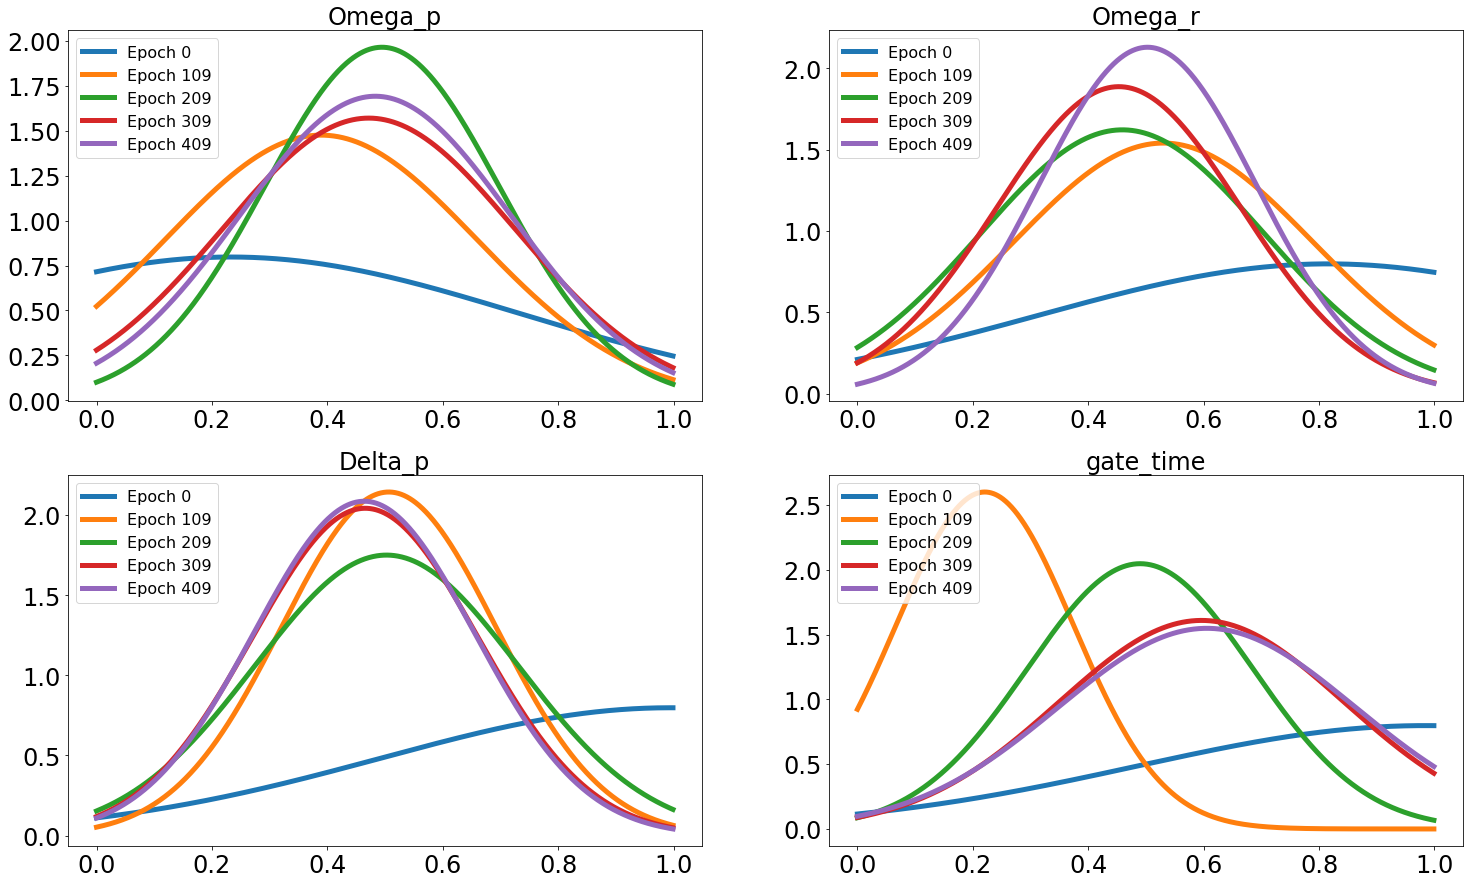

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

x_axis = np.arange(0, 1, 0.001)

plt.figure(figsize=(25, 15))

plt.subplot(221)
for i in [0, 109, 209, 309, 409]:
    plt.plot(x_axis, norm.pdf(x_axis,log['mean_omega_p_amp'][i],log['sigma_omega_p_amp'][i]), linewidth=5, label="Epoch %d" %i)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    
plt.title('Omega_p', fontsize=24)
plt.legend(loc="upper left", fontsize=16)

plt.subplot(222)
for i in [0, 109, 209, 309, 409]:
    plt.plot(x_axis, norm.pdf(x_axis,log['mean_omega_r_amp'][i],log['sigma_omega_r_amp'][i]), linewidth=5, label="Epoch %d" %i)    
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    
plt.title('Omega_r', fontsize=24)
plt.legend(loc="upper left", fontsize=16)

plt.subplot(223)
for i in [0, 109, 209, 309, 409]:
    plt.plot(x_axis, norm.pdf(x_axis,log['mean_delta_p_amp'][i],log['sigma_delta_p_amp'][i]), linewidth=5, label="Epoch %d" %i)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    
plt.title('Delta_p', fontsize=24)
plt.legend(loc="upper left", fontsize=16)

plt.subplot(224)
for i in [0, 109, 209, 309, 409]:
    plt.plot(x_axis, norm.pdf(x_axis,log['mean_gate_time'][i],log['sigma_gate_time'][i]), linewidth=5, label="Epoch %d" %i)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    
plt.title('gate_time', fontsize=24)
plt.legend(loc="upper left", fontsize=16)

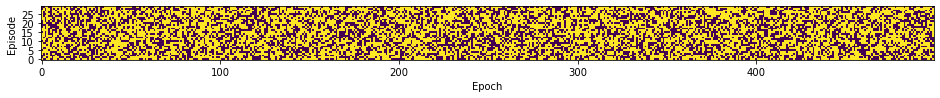

In [12]:
result = np.array(log['train_rewards'])
plt.matshow(np.reshape(result, (EPOCHS, B)).transpose())
plt.xlabel("Epoch")
plt.ylabel("Episode")
plt.gca().invert_yaxis()
plt.gca().tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
# plt.colorbar()

In [13]:
log['mean_omega_r_amp']

[0.8162606,
 0.6187774,
 0.44169223,
 0.38533497,
 0.3288792,
 0.41523036,
 0.51100624,
 0.4869866,
 0.43137532,
 0.5215805,
 0.45921636,
 0.60037905,
 0.5794979,
 0.6434453,
 0.7339646,
 0.6993709,
 0.7333988,
 0.6616792,
 0.66213024,
 0.6602768,
 0.65243924,
 0.62779737,
 0.6745902,
 0.65710366,
 0.6670123,
 0.5476855,
 0.5461472,
 0.46750638,
 0.47313663,
 0.49757883,
 0.49846882,
 0.49607712,
 0.45610267,
 0.4858636,
 0.42695454,
 0.4026102,
 0.3836561,
 0.37296495,
 0.4370699,
 0.53270066,
 0.47992775,
 0.46957484,
 0.55421865,
 0.6007021,
 0.5215211,
 0.5556309,
 0.5639356,
 0.6064251,
 0.6831236,
 0.5959965,
 0.56574076,
 0.4936311,
 0.46822166,
 0.43105844,
 0.40327838,
 0.39044684,
 0.40448347,
 0.4523541,
 0.4673929,
 0.4819669,
 0.4368205,
 0.5060664,
 0.5218013,
 0.5082621,
 0.5764894,
 0.57096964,
 0.5702032,
 0.53537935,
 0.55034465,
 0.55513316,
 0.56735295,
 0.48487163,
 0.48887414,
 0.5105707,
 0.5420518,
 0.5958433,
 0.61828476,
 0.6106597,
 0.6234548,
 0.5072591,
 0.